# Kidney Disease Model Training, Evaluation, and Overfitting Analysis

This notebook provides a comprehensive workflow for the Kidney Disease prediction system:
1. **Training**: Evaluates 5 different machine learning algorithms.
2. **Internal Testing**: Detailed performance metrics and confusion matrices.
3. **Cross-Validation**: Ensuring model stability.
4. **Overfitting Analysis**: Investigating the 100% accuracy result through correlation and learning curves.
5. **External Validation**: Testing against the Albukhary dataset using clinical ground truth rules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
import joblib
import os

print('Libraries imported successfully!')
sns.set_style('whitegrid')

Libraries imported successfully!


## 1. Load and Preprocess UCI Dataset

In [2]:
ML_PATH = 'predictions/ml'
CSV_PATH = os.path.join(ML_PATH, 'kidney.csv')
df = pd.read_csv(CSV_PATH)

rename_map = {
    'Bp': 'Blood Pressure', 'Sg': 'Specific Gravity', 'Al': 'Albumin', 'Su': 'Sugar',
    'Rbc': 'Red Blood Cell', 'Bu': 'Urea', 'Sc': 'Creatinine', 'Sod': 'Sodium',
    'Pot': 'Pottasium', 'Hemo': 'Hemoglobin', 'Wbcc': 'White Blood Cell Count',
    'Rbcc': 'Red Blood Cell Count', 'Htn': 'Hypertension', 'Class': 'Predicted Class'
}
df.rename(columns=rename_map, inplace=True)

# Feature selection
required_cols = ['Predicted Class', 'Creatinine', 'Pottasium', 'Hemoglobin', 
                 'Sodium', 'Blood Pressure', 'Red Blood Cell', 'Urea', 'Albumin']
df = df[required_cols]

# Cleaning
df = df[(df['Pottasium'] <= 7) & (df['Hemoglobin'] <= 20) & (df['Blood Pressure'] >= 50)]
df['Creatinine'] = df['Creatinine'].clip(0, 15)
df['Pottasium'] = df['Pottasium'].clip(2, 7)
df['Hemoglobin'] = df['Hemoglobin'].clip(4, 20)
df['Sodium'] = df['Sodium'].clip(100, 180)
df['Blood Pressure'] = df['Blood Pressure'].clip(60, 180)

X = df.drop('Predicted Class', axis=1)
y = df['Predicted Class']
print(f'Dataset size: {len(df)}')
print(f'Features: {X.columns.tolist()}')

Dataset size: 397
Features: ['Creatinine', 'Pottasium', 'Hemoglobin', 'Sodium', 'Blood Pressure', 'Red Blood Cell', 'Urea', 'Albumin']


## 2. Overfitting Investigation: Correlation & Separation

Checking for Data Leakage via Feature Correlation...
Correlations with Condition:
Predicted Class    1.000000
Albumin            0.598134
Creatinine         0.429985
Urea               0.378658
Blood Pressure     0.301532
Pottasium          0.094308
Red Blood Cell    -0.285570
Sodium            -0.463014
Hemoglobin        -0.731632
Name: Predicted Class, dtype: float64

Visualizing Feature Separation (Creatinine vs Hemoglobin)... 


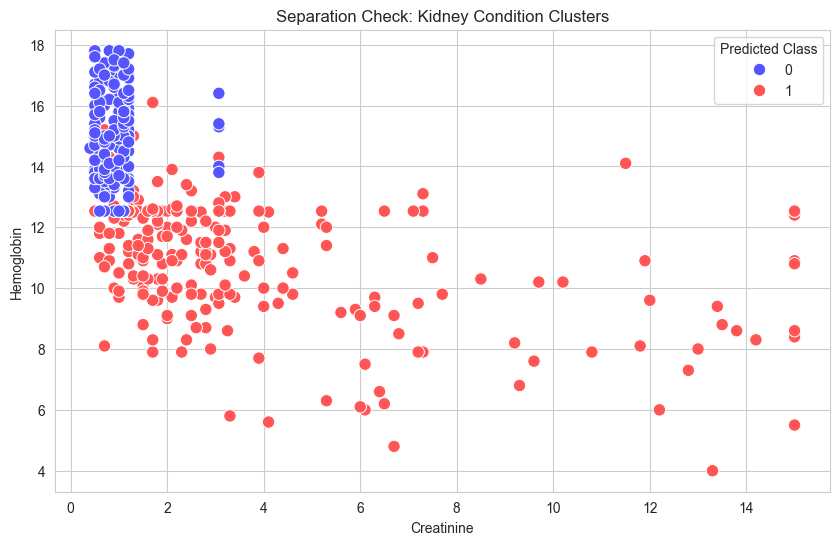

Notice the very clear separation. Medical datasets often have sharp thresholds (e.g. Creatinine > 1.3 usually indicates CKD).


In [3]:
print("Checking for Data Leakage via Feature Correlation...")
corr_matrix = df.corr()
target_corr = corr_matrix['Predicted Class'].sort_values(ascending=False)
print("Correlations with Condition:")
print(target_corr)

print("\nVisualizing Feature Separation (Creatinine vs Hemoglobin)... ")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Creatinine', y='Hemoglobin', hue='Predicted Class', palette='seismic', s=80)
plt.title('Separation Check: Kidney Condition Clusters')
plt.show()
print("Notice the very clear separation. Medical datasets often have sharp thresholds (e.g. Creatinine > 1.3 usually indicates CKD).")

## 3. Train-Test Split and Scaling

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
print(f'Train size: {len(X_train)}, Test size: {len(X_test)}')

Train size: 317, Test size: 80


## 4. Algorithm Comparison and Cross-Validation

In [5]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True),
}

print('Running 5-Fold Cross-Validation...')
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    print(f'{name}: {scores.mean():.4f}')

print('\nTesting on Hold-out Set...')
test_results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    test_results[name] = acc
    print(f'{name}: {acc:.4f}')

Running 5-Fold Cross-Validation...
Logistic Regression: 0.9462
K-Nearest Neighbors: 0.9558
Decision Tree: 0.9179


Random Forest: 0.9431
Support Vector Machine: 0.9463

Testing on Hold-out Set...
Logistic Regression: 0.9625
K-Nearest Neighbors: 0.9875
Decision Tree: 0.9375
Random Forest: 1.0000
Support Vector Machine: 0.9625


## 5. Learning Curves (Bias vs Variance Check)

Generating Learning Curve for Random Forest...


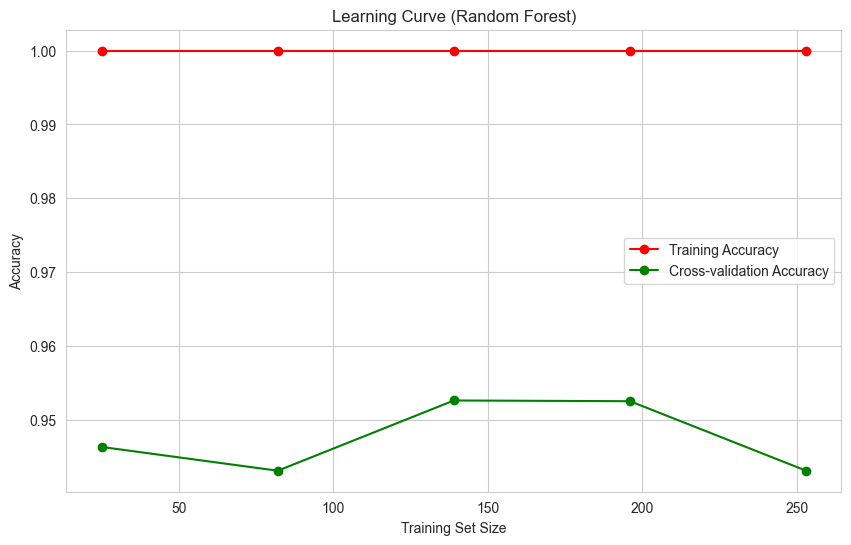

If the curves converge at a high accuracy, the model generalizes well and is NOT severely overfit.


In [6]:
print("Generating Learning Curve for Random Forest...")
best_model_name = 'Random Forest'
model = models[best_model_name]

train_sizes, train_scores, test_scores = learning_curve(
    model, X_train_scaled, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 5), scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training Accuracy')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation Accuracy')
plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()
print("If the curves converge at a high accuracy, the model generalizes well and is NOT severely overfit.")

## 6. Detailed Evaluation

Best Model: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        43

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



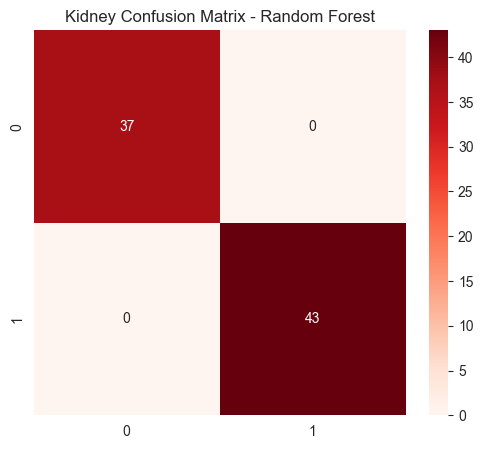

In [7]:
best_name = max(test_results, key=test_results.get)
best_model = models[best_name]
y_pred = best_model.predict(X_test_scaled)

print(f'Best Model: {best_name}')
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title(f'Kidney Confusion Matrix - {best_name}')
plt.show()

## 7. External Validation (Albukhary Dataset)

In [8]:
print('Loading External Albukhary Dataset...')
try:
    ext_df = pd.read_excel('predictions/ml/test_dataset.xlsx')
    
    true_labels = []
    pred_labels = []
    
    for _, row in ext_df.iterrows():
        creatinine = row['Creatnine']
        urea = row['Urea']
        hemoglobin = row['Hemoglobin']
        sodium = row['Sodium']
        potassium = row['Potassium']
        albumin = row['Albumin']
        rbc = row['Red blood Cell']
        
        #SI Unit Conversions
        if pd.notna(creatinine) and creatinine > 20: creatinine /= 88.4
        if pd.notna(urea): urea *= 2.8
        
        # Clinical Ground Truth rule
        risk_score = 0
        if pd.notna(creatinine) and creatinine > 1.3: risk_score += 2
        if pd.notna(urea) and urea > 45: risk_score += 1
        if pd.notna(hemoglobin) and hemoglobin < 12: risk_score += 1
        true_label = "CKD" if risk_score >= 2 else "No CKD"
        
        bp_raw = row['Blood Pressure']
        bp = None
        if isinstance(bp_raw, str) and '/' in bp_raw:
            bp = float(bp_raw.split('/')[1])
        elif pd.notna(bp_raw):
            bp = float(bp_raw)
            
        rbc_val = 0.0 if str(rbc).lower() in ['abnormal', '0'] else 1.0
        
        feats_valid = [creatinine, potassium, hemoglobin, sodium, bp, rbc_val, urea, albumin]
        if not any(pd.isna(v) for v in feats_valid):
            k_input = pd.DataFrame([feats_valid], columns=X.columns)
            k_sc = scaler.transform(k_input)
            ml_p = "CKD" if best_model.predict(k_sc)[0] == 1 else "No CKD"
            
            true_labels.append(true_label)
            pred_labels.append(ml_p)
            
    print(f'External Validation Accuracy: {accuracy_score(true_labels, pred_labels):.2%}')
    print(classification_report(true_labels, pred_labels))
    
except Exception as e:
    print(f'Error: {e}')

Loading External Albukhary Dataset...


External Validation Accuracy: 100.00%
              precision    recall  f1-score   support

         CKD       1.00      1.00      1.00        16

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16

